<a href="https://colab.research.google.com/github/snaily16/GAN-Implementations-Pytorch/blob/master/CGAN/ConditionalGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-90cfa42a-952b-b3df-24df-6d90fe4e0295)


In [2]:
%matplotlib inline

import time, os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools, pickle, imageio
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchsummary import summary

Set Hyperparameters

In [3]:
# Hyperparameters
batch_size=128
num_epochs=50
image_size=28
stats = (0.5), (0.5)
latent_size=100
n_classes=10
lr = 0.0002
b1 = 0.5
b2=0.999
channels=1
img_shape = (channels, image_size, image_size)

In [4]:
# Device configuration
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda' if cuda else 'cpu')

## Load Dataset

In [5]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_data, batch_size=batch_size ,shuffle=True, drop_last=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# results save folder
if not os.path.isdir('MNIST_cGAN_results'):
    os.mkdir('MNIST_cGAN_results')
if not os.path.isdir('MNIST_cGAN_results/Fixed_results'):
    os.mkdir('MNIST_cGAN_results/Fixed_results')

In [7]:
def normal_init(m, mean, std):
  if isinstance(m, nn.Linear):
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()

## Generator Network

In [8]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.fc1_1 = nn.Linear(latent_size, 256)
    self.bn1_1 = nn.BatchNorm1d(256)
    self.fc1_2 = nn.Linear(n_classes, 256)
    self.bn1_2 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(512,512)
    self.bn2 = nn.BatchNorm1d(512)
    self.fc3 = nn.Linear(512,1024)
    self.bn3 = nn.BatchNorm1d(1024)
    self.fc4 = nn.Linear(1024,np.prod(img_shape))

  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  def forward(self, z, label):
    x = F.relu(self.bn1_1(self.fc1_1(z)))
    y = F.relu(self.bn1_2(self.fc1_2(label)))
    x = torch.cat([x,y],1)
    x = F.relu(self.bn2(self.fc2(x)))
    x = F.relu(self.bn3(self.fc3(x)))
    x = F.tanh(self.fc4(x))
    return x
    #return x.view(x.size(0), image_size, image_size)

In [9]:
G = Generator()
G.weight_init(mean=0, std=0.02)
G.to(device)
print(G)
#summary(G,[(1,28,28),(1,10,10)])

Generator(
  (fc1_1): Linear(in_features=100, out_features=256, bias=True)
  (bn1_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_2): Linear(in_features=10, out_features=256, bias=True)
  (bn1_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)


## Discriminator Network

In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.fc1_1 = nn.Linear(np.prod(img_shape), 1024)
    self.fc1_2 = nn.Linear(n_classes, 1024)
    self.fc2 = nn.Linear(2048,512)
    self.bn2 = nn.BatchNorm1d(512)
    self.fc3 = nn.Linear(512,256)
    self.bn3 = nn.BatchNorm1d(256)
    self.fc4 = nn.Linear(256,1)

  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  def forward(self, input, label):
    x = F.leaky_relu(self.fc1_1(input), 0.2)
    y = F.leaky_relu(self.fc1_2(label), 0.2)
    x = torch.cat([x,y], 1)
    x = F.leaky_relu(self.bn2(self.fc2(x)), 0.2)
    x = F.leaky_relu(self.bn3(self.fc3(x)), 0.2)
    x = F.sigmoid(self.fc4(x))
    return x

In [11]:
D = Discriminator()
D.weight_init(mean=0, std=0.02)
D.to(device)
print(D)

Discriminator(
  (fc1_1): Linear(in_features=784, out_features=1024, bias=True)
  (fc1_2): Linear(in_features=10, out_features=1024, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


## Loss function and Optimizers

In [12]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))

### Helper functions

In [25]:
temp_z_ = torch.rand(10, 100)
fixed_z_ = temp_z_
fixed_y_ = torch.zeros(10, 1)
for i in range(9):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], 0)
    temp = torch.ones(10,1) + i
    fixed_y_ = torch.cat([fixed_y_, temp], 0)


fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)
fixed_y_label_ = torch.zeros(100, 10)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
fixed_y_label_ = Variable(fixed_y_label_.cuda(), volatile=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


In [14]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [15]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [21]:
def generate_random_latent():
  return Variable(torch.rand(batch_size,latent_size).to(device))

def generate_random_labels():
  label = (torch.rand(batch_size, 1)*n_classes).type(torch.LongTensor)
  y = torch.zeros(batch_size,10)
  return Variable(y.scatter_(1, label.view(batch_size, 1),1).to(device))

Training functions

In [17]:
def train_discriminator(images, labels):
  # create labels
  mini_batch = images.shape[0]
  real_labels = Variable(torch.ones(mini_batch).to(device))
  fake_labels = Variable(torch.zeros(batch_size).to(device))
    
  # ============================
  #   Train the discriminator
  # ============================

  # Compute BCELoss using real images
  # where BCE_Loss(x, y): - y * log(D(x,y)) - (1-y) * log(1 - D(x,y))
  # Second term of the loss is always zero since real_labels == 1
  x = Variable(images.view(-1, np.prod(img_shape)).to(device))
  y = torch.zeros(mini_batch, 10)
  y.scatter_(1, labels.view(mini_batch, 1), 1)
  y = Variable(y.to(device))
  
  outputs = D(x, y).squeeze()
  d_real_loss = criterion(outputs, real_labels)
  real_score = outputs

  # compute BCELoss using fake images
  # First term of the loss is always zero since fake_labels == 0
  z = generate_random_latent()
  gen_y = generate_random_labels()

  fake_images = G(z, gen_y)
  outputs = D(fake_images, gen_y).squeeze()
  d_fake_loss = criterion(outputs, fake_labels)
  fake_score = outputs

  # Backprop and optimize
  d_loss = d_real_loss + d_fake_loss
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()

  return d_loss, real_score, fake_score

In [18]:
def train_generator():
  real_labels = Variable(torch.ones(batch_size).to(device))
  
  # ============================
  #    Train the Generator
  # ============================
    
  # compute loss with fake image
  z = generate_random_latent()
  gen_y = generate_random_labels()
  gen_images = G(z, gen_y)
  outputs = D(gen_images, gen_y)

  # train G to maximize log(D(G(z)))
  g_loss = criterion(outputs, real_labels)

  # Backprop and optimize
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()
  
  return g_loss, gen_images

In [26]:
# Start Training
train_hist={}
train_hist['D_losses']=list()
train_hist['G_losses']=list()
train_hist['per_epoch_ptimes']=list()
train_hist['total_ptime']=list()

d_losses, g_losses, real_scores, fake_scores =[],[],[],[]
start_time = time.time()
n=0
for epoch in range(num_epochs):
  D_loss, G_loss = [], []
  epoch_start_time = time.time()
  for images,labels in tqdm(train_loader):
    #images = images.reshape(batch_size, -1).to(device)
    real_imgs = Variable(images.type(torch.FloatTensor))
    labels = Variable(labels.type(torch.LongTensor))

    d_loss, real_score, fake_score = train_discriminator(real_imgs,labels)
    g_loss, fake_images = train_generator()

    D_loss.append(d_loss.item())
    G_loss.append(g_loss.item())

    if n%100==0 or n==batch_size:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())
    n+=1
  epoch_end_time = time.time()
  per_epoch_ptime = epoch_end_time - epoch_start_time
  print("[%d/%d] Time taken: %.2f, d_loss: %.3f, g_loss: %.3f" % (epoch+1, num_epochs,
                                                                 per_epoch_ptime, 
                                                                 torch.mean(torch.FloatTensor(D_loss)),
                                                                 torch.mean(torch.FloatTensor(G_loss))))
  path = 'MNIST_cGAN_results/Fixed_results/sample'+str(epoch+1)+'.png'
  show_result(epoch+1, save=True, path=path)
  train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_loss)))
  train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_loss)))
  train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_time = end_time - start_time
train_hist['total_ptime'].append(total_time)

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



[1/50] Time taken: 12.65, d_loss: 0.883, g_loss: 1.420



[2/50] Time taken: 13.02, d_loss: 0.625, g_loss: 1.907



[3/50] Time taken: 12.97, d_loss: 0.801, g_loss: 1.624



[4/50] Time taken: 12.77, d_loss: 0.668, g_loss: 1.956



[5/50] Time taken: 12.85, d_loss: 0.760, g_loss: 1.825



[6/50] Time taken: 12.92, d_loss: 0.785, g_loss: 1.736



[7/50] Time taken: 12.94, d_loss: 0.828, g_loss: 1.638



[8/50] Time taken: 12.95, d_loss: 0.796, g_loss: 1.716



[9/50] Time taken: 12.80, d_loss: 0.577, g_loss: 2.338



[10/50] Time taken: 13.02, d_loss: 0.803, g_loss: 1.765



[11/50] Time taken: 12.96, d_loss: 0.860, g_loss: 1.596



[12/50] Time taken: 12.88, d_loss: 0.889, g_loss: 1.551



[13/50] Time taken: 12.87, d_loss: 0.890, g_loss: 1.587



[14/50] Time taken: 12.86, d_loss: 0.886, g_loss: 1.558



[15/50] Time taken: 12.88, d_loss: 0.933, g_loss: 1.507



[16/50] Time taken: 12.89, d_loss: 0.870, g_loss: 1.660



[17/50] Time taken: 12.83, d_loss: 0.901, g_loss: 1.641



[18/50] Time taken: 12.96, d_loss: 0.913, g_loss: 1.544



[19/50] Time taken: 13.27, d_loss: 0.922, g_loss: 1.517



[20/50] Time taken: 13.27, d_loss: 0.986, g_loss: 1.422



[21/50] Time taken: 13.29, d_loss: 0.960, g_loss: 1.471



[22/50] Time taken: 13.18, d_loss: 0.945, g_loss: 1.486



[23/50] Time taken: 12.84, d_loss: 0.978, g_loss: 1.406



[24/50] Time taken: 12.74, d_loss: 0.981, g_loss: 1.377



[25/50] Time taken: 13.02, d_loss: 0.975, g_loss: 1.403



[26/50] Time taken: 12.94, d_loss: 0.937, g_loss: 1.467



[27/50] Time taken: 12.86, d_loss: 0.826, g_loss: 1.636



[28/50] Time taken: 12.86, d_loss: 0.892, g_loss: 1.524



[29/50] Time taken: 12.82, d_loss: 0.866, g_loss: 1.583



[30/50] Time taken: 13.06, d_loss: 0.883, g_loss: 1.503



[31/50] Time taken: 12.74, d_loss: 0.871, g_loss: 1.513



[32/50] Time taken: 12.71, d_loss: 0.851, g_loss: 1.558



[33/50] Time taken: 12.71, d_loss: 0.848, g_loss: 1.575



[34/50] Time taken: 12.84, d_loss: 0.843, g_loss: 1.590



[35/50] Time taken: 12.77, d_loss: 0.816, g_loss: 1.593



[36/50] Time taken: 12.90, d_loss: 0.793, g_loss: 1.646



[37/50] Time taken: 12.84, d_loss: 0.787, g_loss: 1.676



[38/50] Time taken: 12.87, d_loss: 0.746, g_loss: 1.711



[39/50] Time taken: 12.82, d_loss: 0.742, g_loss: 1.735



[40/50] Time taken: 12.94, d_loss: 0.743, g_loss: 1.778



[41/50] Time taken: 13.13, d_loss: 0.699, g_loss: 1.798



[42/50] Time taken: 12.84, d_loss: 0.679, g_loss: 1.812



[43/50] Time taken: 12.77, d_loss: 0.684, g_loss: 1.870



[44/50] Time taken: 12.84, d_loss: 0.658, g_loss: 1.895



[45/50] Time taken: 12.94, d_loss: 0.661, g_loss: 1.909



[46/50] Time taken: 12.87, d_loss: 0.671, g_loss: 1.913



[47/50] Time taken: 12.96, d_loss: 0.654, g_loss: 1.956



[48/50] Time taken: 13.36, d_loss: 0.635, g_loss: 1.983



[49/50] Time taken: 13.09, d_loss: 0.619, g_loss: 2.017



[50/50] Time taken: 13.19, d_loss: 0.618, g_loss: 2.033


Text(0.5, 1.0, 'Training Losses')

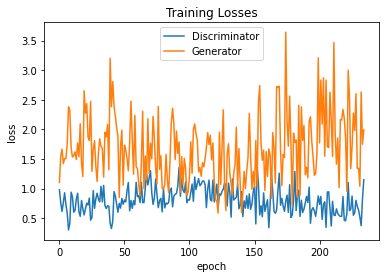

In [27]:
# plot loss
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Training Losses')

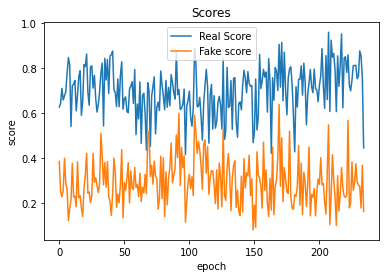

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [35]:
png_dir = 'MNIST_cGAN_results/Fixed_results/'
images = []
for file_name in os.listdir(png_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('demo.gif', images,fps=1)